In [2]:
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
# Reduce logging output.
tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)

# Getting started

## Data
We will try to solve the [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/) task [(Mass et al., 2011)](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as **negative** or **positive**.

In [3]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,"On the 28th of December, 1895, in the Grand Ca...",8,1
1,A really sweet movie that has some similaritie...,7,1
2,"I wanted to like this film, yes its a SAW, bla...",2,0
3,"After we counted the use of the f word, oh, ab...",1,0
4,I had never heard of this Adam Sandler movie u...,1,0


## Model
### Input functions

[Estimator framework](https://www.tensorflow.org/get_started/premade_estimators#overview_of_programming_with_estimators) provides [input functions](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn) that wrap Pandas dataframes.

In [29]:
dataset = tf.data.Dataset.from_tensor_slices((list(train_df['sentence'].values), 
                                              list(train_df['polarity'].values))
                                            )
train_examples_batch, train_labels_batch = next(iter(dataset.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"On the 28th of December, 1895, in the Grand Caf\xc3\xa9 in Paris, film history was writing itself while Louis Lumi\xc3\xa8re showed his short films, all single shots, to a paying audience. 'La Sortie des Usines Lumi\xc3\xa8re' was the first film to be played and I wish I was there, not only to see the film, but also the reactions of the audience.<br /><br />We start with closed doors of the Lumi\xc3\xa8re factory. Apparently, since the image seems a photograph, people thought they were just going to see a slide show, not something they were hoping for. But then the doors open and people are streaming out, heading home. First a lot of women, then some men, and one man on a bike with a big dog. When they are all out the doors close again.<br /><br />Whether this is the first film or not (some say 'L'Arriv\xc3\xa9e d'un Train \xc3\xa0 la Ciotat' was the first film Lumi\xc3\xa8re recorded), it is an impressive piece of early cinema. Be

### Feature columns

TF-Hub provides a [feature column](https://www.tensorflow.org/hub/api_docs/python/hub/text_embedding_column.md) that applies a module on the given text feature and passes further the outputs of the module. In this tutorial we will be using the [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1). For the purpose of this tutorial, the most important facts are:

* The module takes **a batch of sentences in a 1-D tensor of strings** as input.
* The module is responsible for **preprocessing of sentences** (e.g. removal of punctuation and splitting on spaces).
* The module works with any input (e.g. **nnlm-en-dim128** hashes words not present in vocabulary into ~20.000 buckets).

In [32]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.7503022 , -3.691709  ,  3.4338055 , -0.3228845 , -5.3861475 ,
        -3.3654926 , -3.3583605 , -0.6712539 ,  2.3434281 , -0.20047742,
        -3.8665614 ,  2.3881001 , -2.1936314 , -0.17780904, -5.132758  ,
         3.0560794 ,  2.9670174 , -2.6617274 , -4.2043767 , -0.23875079],
       [ 2.1032414 , -2.3249724 ,  2.3480783 , -1.397995  , -3.4095972 ,
        -0.92359406, -1.9300486 ,  0.20443074,  2.04748   , -1.5963868 ,
        -1.5896814 ,  1.3238504 , -0.4017688 ,  0.17756465, -3.9853427 ,
         0.45209408,  2.6965835 , -0.82818305, -2.8581932 , -1.5970742 ],
       [ 1.5073627 , -3.6261086 ,  3.1094828 ,  0.07493318, -4.25405   ,
        -3.4359334 , -2.263075  ,  0.3283306 ,  4.0120006 , -0.6195089 ,
        -1.5973355 ,  0.5930475 , -0.9117889 ,  0.7780605 , -4.8407664 ,
         2.2263017 ,  4.2426443 , -2.1924198 , -2.8274171 , -1.1459619 ]],
      dtype=float32)>

### Estimator

For classification we can use a [DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) (note further remarks about different modelling of the label function at the end of the tutorial).

In [33]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training

Train the estimator for a reasonable amount of steps.

In [36]:
history = model.fit(dataset.shuffle(10000).batch(512),
                    epochs=20,
                    #validation_data=validation_data.batch(512),
                    verbose=1)

Train for 49 steps
Epoch 1/20
49/49 [==============================] - 3s 53ms/step - loss: 0.6948 - accuracy: 0.6079
Epoch 2/20
49/49 [==============================] - 2s 45ms/step - loss: 0.5687 - accuracy: 0.6820
Epoch 3/20
49/49 [==============================] - 2s 46ms/step - loss: 0.5074 - accuracy: 0.7333
Epoch 4/20
49/49 [==============================] - 2s 41ms/step - loss: 0.4566 - accuracy: 0.7732
Epoch 5/20
49/49 [==============================] - 2s 41ms/step - loss: 0.4071 - accuracy: 0.8094
Epoch 6/20
49/49 [==============================] - 2s 40ms/step - loss: 0.3619 - accuracy: 0.8363
Epoch 7/20
49/49 [==============================] - 2s 43ms/step - loss: 0.3246 - accuracy: 0.8572
Epoch 8/20
49/49 [==============================] - 2s 45ms/step - loss: 0.2929 - accuracy: 0.8729
Epoch 9/20
49/49 [==============================] - 2s 45ms/step - loss: 0.2662 - accuracy: 0.8878
Epoch 10/20
49/49 [==============================] - 2s 44ms/step - loss: 0.2455 - accurac

# Prediction

Run predictions for both training and test set.

In [78]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Training set accuracy: 0.8233199715614319
Test set accuracy: 0.8000400066375732


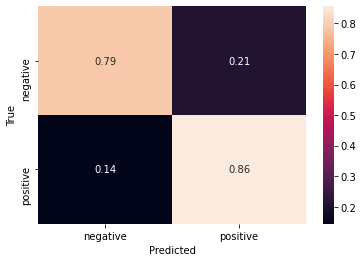

In [77]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
cm = tf.math.confusion_matrix(train_df["polarity"], 
                              get_predictions(estimator, predict_train_input_fn))

# Normalize the confusion matrix so that each row sums to 1.
cm = tf.cast(cm, dtype=tf.float32)
cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]

a = tf.Session().run(cm)

sns.heatmap(a, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");